In [130]:
import numpy as np
import pandas as pd
import scipy.stats as st
import torch
from torch import nn
from torch.utils.data import dataset as Dataset
from torch.utils.data import dataloader as Dataloader
import torchvision
import time
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
loss = nn.MSELoss()
# optimizer = torch.optim.Adam()
nn.Unflatten()

In [123]:
#继承Module类主要是为了能够在定义forward时实现autograde
class VAE(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = input_size

        self.encoder_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        self.decoder_net = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, self.output_size),
            nn.Unflatten(1, (1, 28, 28))
        ) 

    def encoder(self, X):
        assert isinstance(X, torch.Tensor)
        return self.encoder_net(X)

    def decoder(self, X):
        assert isinstance(X, torch.Tensor)
        return self.decoder_net(X)

    def forward(self, X):
        X = self.encoder(X)
        X = self.decoder(X)
        return X

In [40]:
test1 = torch.Tensor(np.random.randint(0, 2, size=(1, 28*28)))

In [56]:
#正则化[0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]， 但是对于单通道图片只要(0.4914,), (0.2023,)
###三个数字数组代表三通道，一个代表单通道
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914,), (0.2023,))]
)
mnist_data = torchvision.datasets.MNIST('D:/Code_software/Jupyter_Notebook/data/mnist/test', transform=transforms)

In [118]:
len_mnidata = len(mnist_data)
len_data = 10000
train_pct = 0.8
train_samples = round(len_data * train_pct)
subset, _ = Dataset.random_split(mnist_data, [len_data, len_mnidata - len_data])
training_set, valid_set = Dataset.random_split(subset, [train_samples, len_data - train_samples])

In [114]:
batch_size = 256

In [119]:
#图片+label
train_iter = Dataloader.DataLoader(training_set, batch_size, shuffle=True)
valid_iter = Dataloader.DataLoader(valid_set, batch_size, shuffle=True)

In [91]:
class Accumulator():
    def __init__(self, n):
        self.ls = [0.0] * n

    def add(self, *args):
        self.ls = [a + float(b) for a, b in zip(self.ls, args)]

    def __getitem__(self, index):
        return self.ls[index]

    def reset(self):
        self.ls = [0.0] * len(self.ls)

In [150]:
def accuracy(y, y_hat):
    # if len(y_hat.shape) > 1 and len(y_hat.shape[1]) > 1:
    #     y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y_hat.dtype).sum())

def eval_accuracy(net, data_iter):
    if isinstance(net, nn.Module):
        net.eval()
    counter = Accumulator(2)
    for X, _ in data_iter:
        X = X.to(device)
        acc = accuracy(X, net(X))
        counter.add(acc, X.numel())
    return [counter[0], counter[1]]

In [155]:
def train(net, train_iter, valid_iter, epochs, loss, lr, device):
    if isinstance(net, nn.Module):
        net.train()
    net = net.to(device)
    train_optim = torch.optim.Adam(net.parameters(), lr=lr)
    metric = Accumulator(2)
    ls = []
    for i in range(epochs):
        start_time = time.time()
        for X, _ in train_iter:
            X = X.to(device)
            train_optim.zero_grad()
            l = loss(net(X), X)
            l.backward()
            train_optim.step()
            metric.add(l * len(X), len(X)) #shape (batchs_size, 通道, h, w)
        time_cost = time.time() - start_time
        if (i + 1) % 5 == 0:
            acc = eval_accuracy(net, train_iter)
            ls.append([metric[0] / metric[1], acc, acc[0] / acc[1], np.round(time_cost, 3)])
        metric.reset()
    return ls

In [156]:
vae = VAE(28*28, 28*28)
epochs, lr = 50, 0.01
device = torch.device("cuda")

In [99]:
# vae.named_parameters()
torch.cuda.is_available()

<function torch.cuda.is_available() -> bool>

In [161]:
ct = 0
rd_index = np.array([10, 13, 3])
for X, y in train_iter:
    if ct == 0:
        print(X, len(X), y.numel(), X[rd_index].shape)
        ct += 1
    else: break

tensor([[[[-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          ...,
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]]],


        [[[-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          ...,
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]]],


        [[[-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
          [-2.4291, -2.429

In [189]:
train(vae, train_iter, valid_iter, epochs, loss, lr, device)

[[0.8813672795295715, [2.0, 6272000.0], 3.1887755102040816e-07, 1.603],
 [0.8762503733634949, [4.0, 6272000.0], 6.377551020408163e-07, 1.513],
 [0.8756610550880433, [4.0, 6272000.0], 6.377551020408163e-07, 1.566],
 [0.8738122658729554, [13.0, 6272000.0], 2.072704081632653e-06, 1.594],
 [0.8654457964897155, [8.0, 6272000.0], 1.2755102040816327e-06, 1.652],
 [0.868292818069458, [4.0, 6272000.0], 6.377551020408163e-07, 1.572],
 [0.8634440417289734, [8.0, 6272000.0], 1.2755102040816327e-06, 1.491],
 [0.8685099983215332, [5.0, 6272000.0], 7.971938775510204e-07, 1.475],
 [0.87437335729599, [10.0, 6272000.0], 1.5943877551020409e-06, 1.785],
 [0.8632345886230469, [9.0, 6272000.0], 1.4349489795918367e-06, 1.657]]

In [186]:
def valid_test(net, valid_iter, device):
    if isinstance(net, nn.Module):
        net.eval()
    switch = 0
    np_pic = []
    for X, _ in valid_iter:
        if switch == 0:
            rand_index = np.random.randint(0, 255, 3)
            X_sub = X[rand_index].to(device)
            output = net(X_sub).to("cpu")
            X_sub = X_sub.to("cpu")
            for i in output:
                np_pic.append(i.permute(1, 2, 0).detach().numpy())
            for j in X_sub:
                np_pic.append(j.permute(1, 2, 0).numpy())
            
            return np_pic
        else:
            break

In [196]:
tst_pic = valid_test(vae, valid_iter, device)

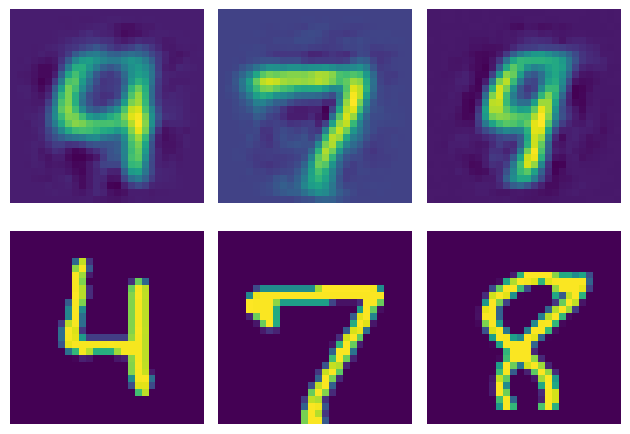

In [197]:
fig, ax = plt.subplots(2, 3)
ax = ax.flatten()
for i, axes in enumerate(ax):
    axes.imshow(tst_pic[i])
    axes.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
for net in vae.encoder_net.children():
    print(net.__class__.__name__, f'the shape of this layer is', net(test1).shape)
    test1 = net(test1)